
<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning">
</div>


# Unsupervised Learning
In this demo, we will explore **unsupervised learning**, a method where the model finds patterns in **unlabeled data** without predefined categories. We will use **text embeddings** to convert text into numerical representations and apply **K-Means clustering** to group similar text documents.

To improve clustering efficiency, we will **reduce the dimensionality** of embeddings using **Principal Component Analysis (PCA)**. We will also use evaluation techniques like the **Elbow Method** and [**Silhouette Score**](https://en.wikipedia.org/wiki/Silhouette_(clustering) to determine the best number of clusters and assess clustering quality.

**Learning Objectives**

By the end of this demo, you will be able to:

- **Generate text embeddings** using the embeddings model  [General Text Embeddings (GTE)](https://huggingface.co/thenlper/gte-large) to represent text numerically.  
- **Apply dimensionality reduction** (PCA) to optimize clustering performance.  
- **Train an unsupervised K-Means model** to discover patterns in text data.  
- **Determine the optimal number of clusters** using the **Elbow Method**.  
- **Evaluate clustering quality** using **Silhouette Score**.  
- **Visualize clustering results** for better interpretability.

In [0]:
%pip install --upgrade threadpoolctl scikit-learn
%pip install kneed
%restart_python

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


## REQUIRED - SELECT CLASSIC COMPUTE
Before executing cells in this notebook, please select your classic compute cluster in the lab. Be aware that **Serverless** is enabled by default.
Follow these steps to select the classic compute cluster:
1. Navigate to the top-right of this notebook and click the drop-down menu to select your cluster. By default, the notebook will use **Serverless**.
1. If your cluster is available, select it and continue to the next cell. If the cluster is not shown:
   - In the drop-down, select **More**.
   - In the **Attach to an existing compute resource** pop-up, select the first drop-down. You will see a unique cluster name in that drop-down. Please select that cluster.
  
**NOTE:** If your cluster has terminated, you might need to restart it in order to select it. To do this:
1. Right-click on **Compute** in the left navigation pane and select *Open in new tab*.
1. Find the triangle icon to the right of your compute cluster name and click it.
1. Wait a few minutes for the cluster to start.
1. Once the cluster is running, complete the steps above to select your cluster.

## Requirements

Please review the following requirements before starting the lesson:

* To run this notebook, you need to use one of the following Databricks runtime(s): **16.3.x-cpu-ml-scala2.12**


## Classroom Setup

Before starting the demo, run the provided classroom setup script. This script will define configuration variables necessary for the demo. Execute the following cell:

In [0]:
%run ../Includes/Classroom-Setup-1.1bUS

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


Dataset saved at dbacademy.labuser11091541_1754532261.ag_news_table


2025/08/07 02:29:31 INFO databricks.ml_features._compute_client._compute_client: Setting columns ['unique_id'] of table 'dbacademy.labuser11091541_1754532261.ag_news_features' to NOT NULL.
2025/08/07 02:29:32 INFO databricks.ml_features._compute_client._compute_client: Setting Primary Keys constraint ['unique_id'] on table 'dbacademy.labuser11091541_1754532261.ag_news_features'.
2025/08/07 02:29:37 INFO databricks.ml_features._compute_client._compute_client: Created feature table 'dbacademy.labuser11091541_1754532261.ag_news_features'.


Feature table created: dbacademy.labuser11091541_1754532261.ag_news_features


**Other Conventions:**

Throughout this demo, we'll refer to the object `DA`. This object, provided by Databricks Academy, contains variables such as your username, catalog name, schema name, working directory, and dataset locations. Run the code block below to view these details:

In [0]:
print(f"Username:          {DA.username}")
print(f"Catalog Name:      {DA.catalog_name}")
print(f"Schema Name:       {DA.schema_name}")
print(f"Working Directory: {DA.paths.working_dir}")
print(f"Dataset Location:  {DA.paths.datasets}")

Username:          labuser11091541_1754532261@vocareum.com
Catalog Name:      dbacademy
Schema Name:       labuser11091541_1754532261
Working Directory: /Volumes/dbacademy/ops/labuser11091541_1754532261@vocareum_com
Dataset Location:  NestedNamespace (california_housing='/Volumes/dbacademy_california_housing/v02', cdc_diabetes='/Volumes/dbacademy_cdc_diabetes/v01', telco='/Volumes/dbacademy_telco/v01', banking='/Volumes/dbacademy_banking/v01')


## Load Data & Generate Embeddings

Before we can apply **unsupervised learning**, we need to load and process our dataset. In this step, we will:

- Load the **AG News dataset** from a **Databricks feature table**.
- Extract the **text column** for processing.
- Prepare the data for **embedding generation**.

### Load the Dataset
We use the **AG News dataset**, which contains news articles, to perform text clustering. The dataset is stored in a **Databricks feature table**, and we will load it as a **Spark DataFrame**.

In [0]:
import os
from pyspark.sql.functions import col

# Load AG News dataset as a Spark DataFrame (Feature Table)
table_name = f"{DA.catalog_name}.{DA.schema_name}.ag_news_features"
news_df = spark.read.table(table_name)

# Select only the 'text' column (avoiding unnecessary columns)
news_texts_df = news_df.select(col("text"))

# Display the Spark DataFrame
display(news_texts_df)

text
"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
"Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
"Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
"Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."
"Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)"
"Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by #36;1.17 billion in the latest week to #36;849.98 trillion, the Investment Company Institute said Thursday."
"Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump."
"Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, ""buying insurance was the furthest thing from my mind,"" says Riley."
"Wall St. Bears Claw Back Into the Black NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again."


### Generate Text Embeddings Using gte-large

Now that we have loaded our text dataset, the next step is to convert the text data into **numerical representations** using **text embeddings**. Here we will demonstrate how easy it is to take our text and embed it using a foundational model from Mosaic AI Model Serving. In particular, we will be using the `get_open_ai_client()` method, which is part of the databricks SDK that provides a convenient way to create an OpenAI-compatible client for interacting with the foundation model. For other methods of querying, please see [this documentation](https://learn.microsoft.com/en-us/azure/databricks/machine-learning/model-serving/score-foundation-models). 

**Steps:**
- Step 1: Initialize OpenAI Client
- Step 2: Define Embedding Function
- Step 3: Convert Text to Embeddings
- Step 4: Convert embeddings list to a Spark DataFrame

In [0]:
from pyspark.sql.functions import col
from databricks.sdk import WorkspaceClient
# Initialize Databricks OpenAI Client
workspace_client = WorkspaceClient()
openai_client = workspace_client.serving_endpoints.get_open_ai_client()

# Function to get embeddings for a batch of text
def get_embeddings_batch(text):
    response = openai_client.embeddings.create(
        model="databricks-gte-large-en",
        input=text
    )
    return [res.embedding for res in response.data]
    
# Convert DataFrame to list on the driver
news_texts_list = news_texts_df.select("text").rdd.map(lambda row: row["text"]).collect()
# Process in batches to reduce API calls
batch_size = 100  # Adjust as needed based on API rate limits
embeddings_list = []

for i in range(0, len(news_texts_list), batch_size):
    batch = news_texts_list[i:i + batch_size]
    embeddings_list.extend(get_embeddings_batch(batch))

# Create DataFrame with embeddings
embeddings_df = spark.createDataFrame(zip(news_texts_list, embeddings_list), ["text", "embedding"])

[Trace(request_id=tr-524c05c53d944a9d855ea41253f65b2f), Trace(request_id=tr-426a14b5c6b44c4baeb8c30089c716c7), Trace(request_id=tr-859a3ddad48c420e996bec51a7b4cff7), Trace(request_id=tr-bfced7b8e7974161ad17b614e1d75f2d), Trace(request_id=tr-9df4767b3f604eea8cc8ce060a43c8bf), Trace(request_id=tr-b57f2883490843059cda84c15acea681), Trace(request_id=tr-639290d9a08d440dafe679bb93ebbf41), Trace(request_id=tr-f4c464b09a784d8d85d1370189288049), Trace(request_id=tr-6502f4c165434f29b2cec54718d2c9ce), Trace(request_id=tr-1ba1513083ee4c59b74085200e38934b)]

In [0]:
embeddings_df.limit(20).display()

text embedding Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again. List(-0.50830078125, 0.07379150390625, -1.0771484375, -0.0279388427734375, -0.402099609375, 0.442626953125, -0.56591796875, 0.007801055908203125, -0.239013671875, 0.1279296875, 0.2481689453125, -0.52880859375, -0.00862884521484375, 0.85888671875, 0.292724609375, 1.18359375, -0.54150390625, -0.1705322265625, 0.57080078125, -0.76611328125, -0.40869140625, -0.07452392578125, -0.59228515625, 0.454833984375, 0.477783203125, 1.439453125, 0.54443359375, 0.1710205078125, 0.371337890625, -1.12890625, -0.13623046875, -0.244384765625, 0.6748046875, 0.1083984375, -0.6083984375, 0.2469482421875, 0.50537109375, 0.134765625, 0.35302734375, 0.386962890625, -0.8564453125, -0.5908203125, -0.7099609375, -0.449951171875, 0.281494140625, -0.11968994140625, -0.34814453125, 0.1361083984375, 0.3203125, 0.47021484375, -0.87109375, 0.32763671875, -0.3857421875, -0.047332763671875, 0.3818359375, -1.15625, 0.09918212890625, -0.71240234375, 1.6064453125, -0.625, -0.7666015625, 0.2274169921875, -0.242919921875, -0.953125, -0.57958984375, 1.0048828125, -0.459228515625, -0.29345703125, -0.8720703125, -1.2314453125, -0.771484375, 0.67333984375, 0.12225341796875, -0.241455078125, -0.200927734375, -0.31591796875, -0.921875, 0.63330078125, 0.51513671875, 0.54345703125, 0.26123046875, 0.57470703125, 0.2410888671875, 0.1712646484375, -2.23828125, 0.658203125, 0.98583984375, 0.5849609375, -0.2261962890625, 1.4755859375, 0.262451171875, -0.2156982421875, 0.57763671875, -0.478271484375, 0.30810546875, 0.58154296875, -1.2568359375, 0.7626953125, -0.2171630859375, 0.202392578125, -0.07720947265625, 0.041717529296875, -0.63623046875, -0.144775390625, -0.74951171875, 1.1083984375, 0.0229034423828125, 0.041839599609375, -1.8486328125, -0.73388671875, 0.5546875, 0.54638671875, 0.09783935546875, -0.2281494140625, -0.424072265625, 0.489501953125, -0.1279296875, -1.2919921875, -0.1981201171875, -0.64501953125, -0.720703125, -0.10382080078125, 0.059906005859375, 0.03515625, 0.443603515625, -0.32080078125, 0.63720703125, -0.106201171875, 0.01137542724609375, 0.2705078125, -0.21875, 0.362060546875, -0.26416015625, -0.63525390625, 0.703125, 0.1380615234375, -0.107421875, -0.354248046875, 0.67333984375, -0.11993408203125, -0.344482421875, -0.0697021484375, 2.064453125, 0.478515625, 0.16845703125, -0.21875, -0.708984375, 0.6875, -0.51318359375, 0.0975341796875, -0.66552734375, -0.78515625, -0.3681640625, 0.360107421875, -0.037109375, -0.419677734375, -0.07025146484375, -0.00734710693359375, 0.1915283203125, -0.521484375, -0.09234619140625, 0.71435546875, 0.301025390625, -0.450439453125, -0.478515625, -0.1431884765625, 0.8779296875, -0.0389404296875, -0.152099609375, 0.81494140625, -0.0950927734375, -0.390869140625, -0.1031494140625, -0.005710601806640625, -0.10107421875, -0.8271484375, -0.00565338134765625, 1.228515625, 0.68603515625, 0.68408203125, -0.43701171875, 0.00975799560546875, -0.1575927734375, -0.7568359375, -1.2255859375, -1.1787109375, -0.00524139404296875, 0.78515625, 1.2822265625, -0.410888671875, -0.408447265625, -0.11297607421875, -0.5107421875, -1.146484375, -0.2274169921875, -0.17724609375, -0.37890625, 0.375732421875, -0.69384765625, 0.1907958984375, -0.36669921875, -0.4453125, -0.8251953125, -1.107421875, 0.391845703125, -1.23046875, -0.158935546875, -0.481201171875, -0.669921875, 0.72998046875, 0.332763671875, -1.134765625, 1.396484375, 0.4365234375, 0.07421875, 0.250244140625, -0.10205078125, -0.72412109375, -0.237548828125, 0.37646484375, -1.75390625, 0.239990234375, 0.59521484375, 0.1435546875, 1.23046875, 0.37744140625, 0.6630859375, -0.282470703125, 0.7109375, 0.6669921875, -1.0546875, -0.2054443359375, 0.2093505859375, -1.068359375, -0.369384765625, 0.288330078125, 0.50244140625, -0.365478515625, 0.8994140625, -1.435546875, -0.70458984375, -0.61669921875, 1.0068359375, -0.37841796875, -0.1547851562

In [0]:
# Check if embeddings_list is not empty
if embeddings_list:
    vector_dimension = len(embeddings_list[0])
    print(f"Vector dimension of embeddings: [{len(embeddings_list)}, {vector_dimension}]")
else:
    print("The embeddings_list is empty.")

Vector dimension of embeddings: [1000, 1024]


## Standardization and Dimensionality Reduction

Now that we have generated **text embeddings**, we need to prepare them for clustering by applying **standardization** and **dimensionality reduction**.

**Why Do We Need This Step?**
- **Standardization** ensures that all features have a similar scale, preventing some features from dominating others.
- **Dimensionality Reduction** using [**Principal Component Analysis (PCA)**](https://en.wikipedia.org/wiki/Principal_component_analysis) helps reduce the number of features while retaining important information. This makes clustering more efficient and easier to visualize. In particular, we will be converting our embedding from 1024 dimensions down to 2 dimensions.

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Convert Spark DataFrame to NumPy array (Extract embeddings)
embeddings_np = np.array([row["embedding"] for row in embeddings_df.select("embedding").collect()])

embeddings_np_shape = embeddings_np.shape
print(f"Dimension of embeddings_np: {embeddings_np_shape}")

# Step 1: Standardization
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_np)

# Step 2: Dimensionality Reduction using PCA
pca = PCA(n_components=2)  # Reduce to 2D for visualization
embeddings_pca = pca.fit_transform(embeddings_scaled)

# Convert back to Spark DataFrame
pca_df = spark.createDataFrame(
    [(int(i), float(pc1), float(pc2)) for i, (pc1, pc2) in enumerate(embeddings_pca)],
    ["unique_id", "PC1", "PC2"]
)

# Display the transformed embeddings
display(pca_df)

Dimension of embeddings_np: (1000, 1024)


unique_id,PC1,PC2
0,-2.3593915807009838,2.98729535621034
1,-5.9045850077763395,0.8564254048152701
2,-3.033032523380325,4.022603832170914
3,3.2958490051325793,-7.30557129888904
4,4.00804562076794,-1.9738258563042488
5,-8.449642879139178,4.5501759885176805
6,-2.647511710806249,1.4585739434678289
7,-0.12893687852515412,0.33711997652469367
8,-0.9356504097426405,2.179147711811181
9,-1.2816494975918271,2.104883817681019


## Determine the Optimal Number of Clusters (Elbow Method)

Before applying [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) clustering, we need to determine the **best number of clusters (K)**.  
We use the [**Elbow Method**](https://en.wikipedia.org/wiki/Knee_of_a_curve), which helps identify the point where adding more clusters **no longer significantly reduces inertia (sum of squared distances to cluster centers).**  

**How Does the Elbow Method Work?**
- We run **K-Means** clustering for different values of K (from 1 to 10).
- We measure **inertia** (how well points fit within their assigned cluster).
- We plot inertia against K and look for the [**elbow point**](https://en.wikipedia.org/wiki/Elbow_method_(clustering) where the decrease in inertia slows down.
- The **optimal K** is found using **KneeLocator**, which detects the elbow point automatically.

**Why not just minimize inertia?**
- Minimizing inertia can lead to _overfitting_ (continuously decreasing while increasing the number of clusters will fit noise rather than meaningful patterns).
- The elbow method provides interpretability and voids arbitrary decision-making by providing a point of diminishing returns.

> We manually set the environment variable `OMP_NUM_THREADS` to 1 to avoid multithreading and parallelism to ensure that each run uses the same computational resources. This prevents the creation of too many threads across processes, preventing inefficient CPU utilization.

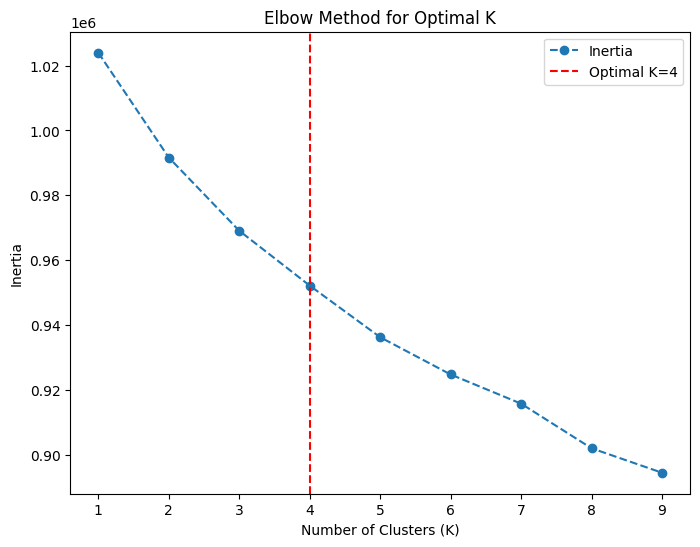

Optimal number of clusters: 4


In [0]:
import os
import threadpoolctl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from kneed import KneeLocator 

# Apply fixes for parallel processing
os.environ["OMP_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(limits=1, user_api="blas")

# Perform K-Means clustering and compute inertia
inertia = []
k_values = range(1, 10)  # Try values from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings_scaled)  # Ensure embeddings_scaled is preprocessed
    inertia.append(kmeans.inertia_)

# Use KneeLocator to find the elbow point
knee_locator = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow

# Plot Elbow Method with detected optimal k
plt.figure(figsize=(8,6))
plt.plot(k_values, inertia, marker='o', linestyle='--', label='Inertia')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.legend()
plt.show()

print(f"Optimal number of clusters: {optimal_k}")

## Apply Clustering Algorithm

We will now apply **K-Means Clustering** to group similar news articles together based on their embeddings.

**Steps:**
1. **Train the K-Means model** using the **optimal_k**.
2. **Assign cluster labels** to each news article.
3. **Store clustering results** in a Spark DataFrame.

In [0]:
from pyspark.sql.functions import monotonically_increasing_id
from sklearn.cluster import KMeans
import pandas as pd

# Apply K-Means clustering on the reduced embeddings
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(embeddings_scaled)  # Fit the model on the standardized embeddings

# Get cluster labels
labels = kmeans.labels_

# Convert labels to a Spark DataFrame
labels_df = pd.DataFrame({"unique_id": range(len(labels)), "Cluster": labels})
labels_spark_df = spark.createDataFrame(labels_df)

# Join PCA-transformed Spark DataFrame with cluster labels
clusters_spark_df = pca_df.join(labels_spark_df, "unique_id")

# Display the resulting clustered DataFrame
display(clusters_spark_df)

unique_id,PC1,PC2,Cluster
0,-2.3593915807009838,2.98729535621034,2
1,-5.9045850077763395,0.8564254048152701,0
2,-3.033032523380325,4.022603832170914,2
3,3.2958490051325793,-7.30557129888904,2
4,4.00804562076794,-1.9738258563042488,2
5,-8.449642879139178,4.5501759885176805,2
6,-2.647511710806249,1.4585739434678289,2
7,-0.12893687852515412,0.33711997652469367,2
8,-0.9356504097426405,2.179147711811181,0
9,-1.2816494975918271,2.104883817681019,2


## Evaluate Clustering Performance

Once the **K-Means clustering** is applied, we need to assess how well the clusters are formed. A common metric for this evaluation is the **Silhouette Score**.

### Silhouette Score
_The silhouette value measures how well an object fits its assigned cluster compared to other clusters_, ranging from -1 to +1, with higher values indicating better clustering. It provides a metric for evaluating clustering quality, with average scores above 0.5 considered reasonable, though high-dimensional data may yield lower scores due to the curse of dimensionality.

In [0]:
labels[:10], embeddings_scaled[:10]

(array([2, 0, 2, 2, 2, 2, 2, 2, 0, 2], dtype=int32),
 array([[-0.6 ,  0.29, -0.93, ...,  1.29, -0.27, -0.84],
        [ 0.51, -0.16,  0.17, ...,  0.81, -1.22, -0.2 ],
        [ 2.53, -0.15, -0.31, ...,  0.71, -0.03,  1.09],
        ...,
        [ 1.17, -0.37, -0.34, ...,  1.8 ,  0.26,  0.82],
        [-0.41,  0.09, -0.94, ...,  0.8 ,  1.03, -2.2 ],
        [-0.6 , -0.03, -0.87, ...,  1.06, -0.49, -1.1 ]]))

In [0]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(embeddings_scaled, labels)
print(f"Silhouette Score for K-Means with {optimal_k} clusters: {silhouette_avg}")

Silhouette Score for K-Means with 4 clusters: 0.03465327960266701


## Visualize Clustering Results

we will visualize the clusters to gain insights into how the news articles are grouped based on their embeddings. Here we will be using the method ConvexHull to help visualize. This compute the convex hull in N dimensions (here N = 2). This helps us identify the boundary of a set of clusters.

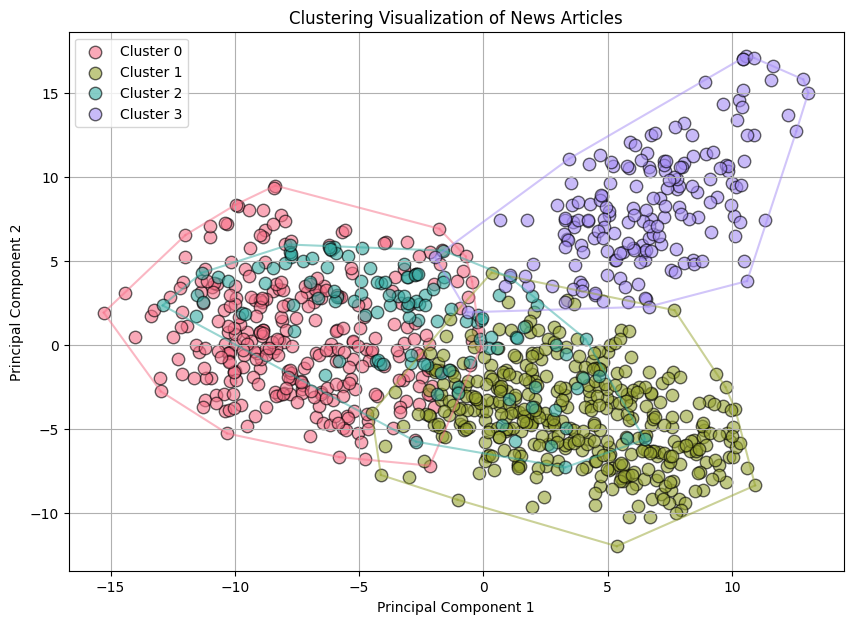

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

# Convert Spark DataFrame to Pandas
clusters_pd = clusters_spark_df.toPandas()

# Define color palette
num_clusters = clusters_pd["Cluster"].nunique()
colors = sns.color_palette("husl", num_clusters)  # Distinct colors

plt.figure(figsize=(10, 7))

# Scatter plot with better visibility
for cluster, color in zip(range(num_clusters), colors):
    subset = clusters_pd[clusters_pd["Cluster"] == cluster]
    
    plt.scatter(
        subset["PC1"], subset["PC2"],
        label=f"Cluster {cluster}",
        color=color, s=80, alpha=0.6, edgecolors='k'  # Larger points, transparency, black edges
    )

    # Convex Hull for cluster boundary (only if there are enough points)
    if len(subset) > 2:
        hull = ConvexHull(subset[["PC1", "PC2"]])
        for simplex in hull.simplices:
            plt.plot(subset.iloc[simplex]["PC1"], subset.iloc[simplex]["PC2"], color=color, alpha=0.5)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Clustering Visualization of News Articles")
plt.legend()
plt.grid(True)
plt.show()

## Conclusion
In this demo, we explored the process of **training an unsupervised model** using **K-Means clustering** on **text embeddings**. We generated embeddings with **Databricks foundation models**, standardized the data, and applied **dimensionality reduction (PCA)** to optimize clustering. By using the **Elbow Method** and **Silhouette Score**, we determined the optimal number of clusters and evaluated the quality of our model. This approach helps in discovering hidden patterns in text data, making it a powerful technique for **automated categorization and pattern recognition** in **real-world applications**.



&copy; 2025 Databricks, Inc. All rights reserved. Apache, Apache Spark, Spark, the Spark Logo, Apache Iceberg, Iceberg, and the Apache Iceberg logo are trademarks of the <a href="https://www.apache.org/" target="blank">Apache Software Foundation</a>.<br/>
<br/><a href="https://databricks.com/privacy-policy" target="blank">Privacy Policy</a> | 
<a href="https://databricks.com/terms-of-use" target="blank">Terms of Use</a> | 
<a href="https://help.databricks.com/" target="blank">Support</a>